# Driver Lifetime Value
This data project was uploaded on StrataScratch, and was used as a take-home assignment in the recruitment process for the data science positions at Lyft.

All timestamps in the data set are in UTC




![Image1](Image1.png)

![Image2](Image2.png)

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import warnings
warnings.filterwarnings('ignore')


In [2]:
df_driver_ids = pd.read_csv('driver_ids.csv')
df_ride_timestamps = pd.read_csv('ride_timestamps.csv')
df_ride_ids = pd.read_csv('ride_ids.csv')

##### Information about df_driver_ids dataframe

In [3]:
df_driver_ids.shape

(937, 2)

In [4]:
df_driver_ids.head(3)

driver_id  driver_onboard_date
0  002be0ffdc997bd5c50703158b7c2491  2016-03-29 00:00:00
1  007f0389f9c7b03ef97098422f902e62  2016-03-29 00:00:00
2  011e5c5dfc5c2c92501b8b24d47509bc  2016-04-05 00:00:00

In [5]:
print('Number of unique driver_ids:', df_driver_ids['driver_id'].nunique())

Number of unique driver_ids: 937


In [6]:
print('Min driver_onboard_date:', df_driver_ids['driver_onboard_date'].min())
print('Max driver_onboard_date:', df_driver_ids['driver_onboard_date'].max())

Min driver_onboard_date: 2016-03-28 00:00:00
Max driver_onboard_date: 2016-05-15 00:00:00


In [7]:
# To check for nulls:
df_driver_ids.isnull().sum()

driver_id              0
driver_onboard_date    0
dtype: int64

##### Information about df_ride_timestamps dataframe

In [8]:
df_ride_timestamps.shape

(970405, 3)

In [9]:
df_ride_timestamps.head(3)

ride_id         event            timestamp
0  00003037a262d9ee40e61b5c0718f7f0  requested_at  2016-06-13 09:39:19
1  00003037a262d9ee40e61b5c0718f7f0   accepted_at  2016-06-13 09:39:51
2  00003037a262d9ee40e61b5c0718f7f0    arrived_at  2016-06-13 09:44:31

In [10]:
print('Number of unique ride_ids:', df_ride_timestamps['ride_id'].nunique())

Number of unique ride_ids: 194081


In [11]:
print('Number of unique event types:', df_ride_timestamps['event'].nunique())

print('Unique event types:', df_ride_timestamps['event'].unique())


Number of unique event types: 5
Unique event types: ['requested_at' 'accepted_at' 'arrived_at' 'picked_up_at' 'dropped_off_at']


In [12]:
# To check for nulls:
df_ride_timestamps.isnull().sum()

ride_id      0
event        0
timestamp    1
dtype: int64

There is only one NULL value in the timestamp column, and no NULLs in any other column.

##### Information about df_ride_ids dataframe

In [13]:
df_ride_ids.shape

(193502, 5)

In [14]:
df_ride_ids.head(3)

driver_id                           ride_id  ride_distance  ride_duration  ride_prime_time
0  002be0ffdc997bd5c50703158b7c2491  006d61cf7446e682f7bc50b0f8a5bea5           1811            327               50
1  002be0ffdc997bd5c50703158b7c2491  01b522c5c3a756fbdb12e95e87507eda           3362            809                0
2  002be0ffdc997bd5c50703158b7c2491  029227c4c2971ce69ff2274dc798ef43           3282            572                0

In [15]:
print('Number of unique driver_ids:', df_ride_ids['driver_id'].nunique())
print('Number of unique ride_ids:', df_ride_ids['ride_id'].nunique())


Number of unique driver_ids: 937
Number of unique ride_ids: 193502


In [16]:
# To check for nulls:
df_ride_ids.isnull().sum()

driver_id          0
ride_id            0
ride_distance      0
ride_duration      0
ride_prime_time    0
dtype: int64

In [17]:
df_driver_ids.describe()

driver_id  driver_onboard_date
count                                937                  937
unique                               937                   49
top     002be0ffdc997bd5c50703158b7c2491  2016-04-05 00:00:00
freq                                   1                   36

In [18]:
df_ride_timestamps.describe()

ride_id         event            timestamp
count                             970405        970405               970404
unique                            194081             5               865826
top     00003037a262d9ee40e61b5c0718f7f0  requested_at  2016-04-30 22:09:15
freq                                   5        194081                    7

In [19]:
df_ride_ids.describe()

ride_distance  ride_duration  ride_prime_time
count  193502.000000  193502.000000    193502.000000
mean     6955.218266     858.966099        17.305893
std      8929.444606     571.375818        30.825800
min        -2.000000       2.000000         0.000000
25%      2459.000000     491.000000         0.000000
50%      4015.000000     727.000000         0.000000
75%      7193.000000    1069.000000        25.000000
max    724679.000000   28204.000000       500.000000

Comparing the mean and 75th percentile of all three columns and looking at the max value, I believe that there might be outliers. We will need to check for outliers.

The cost per ride can be calculated using the assumptions from the Lyft rate card:
*  Base Fare \\$2.00
*  Cost per Mile \\$1.15
*  Cost per Minute \\$0.22
*  Service Fee \\$1.75
*  Minimum Fare \\$5.00
*  Maximum Fare \\$400.00
e

In [20]:
Base_Fare = 2.00
Cost_per_Mile = 1.15
Cost_per_Minute = 0.22
Service_Fee = 1.75
Minimum_Fare = 5.00
Maximum_Fare = 400.00

# Calculating total_ride_cost by converting ride_distance from meters to miles, and convert ride_duration from seconds to minutes
df_ride_ids['total_ride_cost'] = ((Base_Fare + (Cost_per_Minute*(df_ride_ids['ride_duration']/60)) + 
                                   (Cost_per_Mile * (df_ride_ids['ride_distance'] * 0.0006213712))) * 
                                  (1 + df_ride_ids['ride_prime_time']/100)) + Service_Fee

# Apply lower and upper bound to ride cost (Minimum Fare, Maximum Fare )
df_ride_ids['total_ride_cost'] = np.where(df_ride_ids['total_ride_cost'] < Minimum_Fare, Minimum_Fare, df_ride_ids['total_ride_cost'])
df_ride_ids['total_ride_cost'] = np.where(df_ride_ids['total_ride_cost'] > Maximum_Fare, Maximum_Fare, df_ride_ids['total_ride_cost'])

df_ride_ids.head()

driver_id                           ride_id  ride_distance  ride_duration  ride_prime_time  total_ride_cost
0  002be0ffdc997bd5c50703158b7c2491  006d61cf7446e682f7bc50b0f8a5bea5           1811            327               50         8.489648
1  002be0ffdc997bd5c50703158b7c2491  01b522c5c3a756fbdb12e95e87507eda           3362            809                0         9.118741
2  002be0ffdc997bd5c50703158b7c2491  029227c4c2971ce69ff2274dc798ef43           3282            572                0         8.192575
3  002be0ffdc997bd5c50703158b7c2491  034e861343a63ac3c18a9ceb1ce0ac69          65283           3338               25        77.861320
4  002be0ffdc997bd5c50703158b7c2491  034f2e614a2f9fc7f1c2f77647d1b981           4115            823              100        17.666301

In [21]:
df_ride_timestamps.head(3)

ride_id         event            timestamp
0  00003037a262d9ee40e61b5c0718f7f0  requested_at  2016-06-13 09:39:19
1  00003037a262d9ee40e61b5c0718f7f0   accepted_at  2016-06-13 09:39:51
2  00003037a262d9ee40e61b5c0718f7f0    arrived_at  2016-06-13 09:44:31

#### Feature Engineering for Rides

In [22]:
df_ride_events = df_ride_timestamps.pivot(index = 'ride_id', columns = 'event', values = 'timestamp')
df_ride_data = pd.merge(df_ride_ids, df_ride_events, on='ride_id')
df_ride_data.head(3)

driver_id                           ride_id  ride_distance  ride_duration  ride_prime_time  total_ride_cost          accepted_at           arrived_at       dropped_off_at         picked_up_at         requested_at
0  002be0ffdc997bd5c50703158b7c2491  006d61cf7446e682f7bc50b0f8a5bea5           1811            327               50         8.489648  2016-04-23 02:14:15  2016-04-23 02:16:36  2016-04-23 02:22:07  2016-04-23 02:16:40  2016-04-23 02:13:50
1  002be0ffdc997bd5c50703158b7c2491  01b522c5c3a756fbdb12e95e87507eda           3362            809                0         9.118741  2016-03-29 19:00:52  2016-03-29 19:03:57  2016-03-29 19:17:30  2016-03-29 19:04:01  2016-03-29 19:00:49
2  002be0ffdc997bd5c50703158b7c2491  029227c4c2971ce69ff2274dc798ef43           3282            572                0         8.192575  2016-06-21 11:56:39  2016-06-21 12:01:32  2016-06-21 12:11:07  2016-06-21 12:01:35  2016-06-21 11:56:31

In the above cell, we are using the pivot() method of a pandas DataFrame ride_timestamps . The pivot method is used to reshape the data by transforming rows into columns. The resulting DataFrame is stored in a variable called ride_events . The parameters of this method are the following:
 - index : This argument specifies the column to use as the index of the resulting DataFrame. In this case, the ride_id column is used as the index.
 - columns : This argument specifies the column to use as the columns headers of the resulting DataFrame. In this case, the event column is used as  the columns argument.
 - values : This argument specifies the column to use as the values in the resulting DataFrame. In this case, the timestamp column is used as the values argument.

In [23]:
df_ride_data.shape

(184819, 11)

In [24]:
df_ride_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184819 entries, 0 to 184818
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   driver_id        184819 non-null  object 
 1   ride_id          184819 non-null  object 
 2   ride_distance    184819 non-null  int64  
 3   ride_duration    184819 non-null  int64  
 4   ride_prime_time  184819 non-null  int64  
 5   total_ride_cost  184819 non-null  float64
 6   accepted_at      184819 non-null  object 
 7   arrived_at       184818 non-null  object 
 8   dropped_off_at   184819 non-null  object 
 9   picked_up_at     184819 non-null  object 
 10  requested_at     184819 non-null  object 
dtypes: float64(1), int64(3), object(7)
memory usage: 15.5+ MB


In [25]:
df_ride_data.describe()

ride_distance  ride_duration  ride_prime_time  total_ride_cost
count  184819.000000  184819.000000    184819.000000    184819.000000
mean     6941.482223     859.698148        17.383765        13.536731
std      8931.865664     572.540196        30.842380         9.890924
min        -2.000000       2.000000         0.000000         5.000000
25%      2456.000000     492.000000         0.000000         8.036440
50%      4005.000000     727.000000         0.000000        10.567212
75%      7166.000000    1070.000000        25.000000        15.111761
max    724679.000000   28204.000000       500.000000       400.000000

In [26]:
# convert ride distance from meters to kilometers, and ride duration from seconds to minutes
df_ride_data["ride_distance"] = df_ride_data["ride_distance"]/1000
df_ride_data["ride_duration"] = df_ride_data["ride_duration"]/60

df_ride_data['accepted_at']	= pd.to_datetime(df_ride_data['accepted_at'])
df_ride_data['arrived_at'] = pd.to_datetime(df_ride_data['arrived_at'])
df_ride_data['dropped_off_at'] = pd.to_datetime(df_ride_data['dropped_off_at'])
df_ride_data['picked_up_at'] = pd.to_datetime(df_ride_data['picked_up_at'])
df_ride_data['requested_at'] = pd.to_datetime(df_ride_data['requested_at'])

# Ride Date : Convert the accepted_at column from object type to date type.
df_ride_data['ride_date'] = pd.to_datetime(df_ride_data['accepted_at']).dt.date

# Ride Accept Response Time : This metric measures the time a driver takes to accept a ride once it is requested in minutes. 
#                             If the response time is quick, the driver is demonstrating commitment and engagement in their role. 
#                             Conversely, if the response time is consistently slow, it may signify disinterest in the job 
#                             and the potential for resignation.
df_ride_data['ride_accept_response_time'] = (df_ride_data['accepted_at'] - df_ride_data['requested_at']).dt.total_seconds()/60

# Rider Arrival Time : This metric measures the time a driver takes to reach the pickup location after accepting a ride in minutes.
df_ride_data['ride_arrival_time'] = (df_ride_data['arrived_at'] - df_ride_data['accepted_at']).dt.total_seconds()/60

# Driver Wait Time : This metric measures the time a driver waits for the rider once they reach the pickup location in minutes. 
#                    If the driver consistently gets rides with a high wait time, it may be a factor for them to leave the firm.
df_ride_data['ride_wait_time'] = (df_ride_data['picked_up_at'] - df_ride_data['arrived_at']).dt.total_seconds()/60

# Ride Length : This metric categorizes rides into short (less than 8 km), medium (8-20 km), and long (more than 20 km) rides. 
#               It indicates the type of rides a driver generally gets.
df_ride_data["ride_length"] = np.where(df_ride_data["ride_distance"] > df_ride_data['ride_distance'].quantile(0.33), (np.where(df_ride_data["ride_distance"] < df_ride_data['ride_distance'].quantile(0.66), "med_ride", "long_ride")), "short_ride")

# Ride Time : This metric categorizes rides into the morning (6 am – 3 pm), evening (3 pm – 9 pm), and night (9 pm – 6 am) rides. 
#             It determines the time of day when a driver generally works.
df_ride_data["ride_time"] = np.where(pd.to_datetime(df_ride_data['accepted_at']).dt.hour > 6, (np.where(pd.to_datetime(df_ride_data['accepted_at']).dt.hour <= 15, "morning_ride", (np.where(pd.to_datetime(df_ride_data['accepted_at']).dt.hour <= 21, "evening_ride", "night_ride")))), "night_ride")



In [27]:
df_ride_data.head()

driver_id                           ride_id  ride_distance  ride_duration  ride_prime_time  total_ride_cost         accepted_at          arrived_at      dropped_off_at        picked_up_at        requested_at   ride_date  ride_accept_response_time  ride_arrival_time  ride_wait_time ride_length     ride_time
0  002be0ffdc997bd5c50703158b7c2491  006d61cf7446e682f7bc50b0f8a5bea5          1.811       5.450000               50         8.489648 2016-04-23 02:14:15 2016-04-23 02:16:36 2016-04-23 02:22:07 2016-04-23 02:16:40 2016-04-23 02:13:50  2016-04-23                   0.416667           2.350000        0.066667  short_ride    night_ride
1  002be0ffdc997bd5c50703158b7c2491  01b522c5c3a756fbdb12e95e87507eda          3.362      13.483333                0         9.118741 2016-03-29 19:00:52 2016-03-29 19:03:57 2016-03-29 19:17:30 2016-03-29 19:04:01 2016-03-29 19:00:49  2016-03-29                   0.050000           3.083333        0.066667    med_ride  evening_ride
2  002be0ffdc997bd5c50703158b7c2491  029227c4c2971ce69ff2274dc798ef43          3.282       9.533333                0         8.192575 2016-06-21 11:56:39 2016-06-21 12:01:32 2016-06-21 12:11:07 2016-06-21 12:01:35 2016-06-21 11:56:31  2016-06-21                   0.133333           4.883333        0.050000    med_ride  morning_ride
3  002be0ffdc997bd5c50703158b7c2491  034e861343a63ac3c18a9ceb1ce0ac69         65.283      55.633333               25        77.861320 2016-05-19 09:15:33 2016-05-19 09:18:20 2016-05-19 10:13:58 2016-05-19 09:18:20 2016-05-19 09:15:29  2016-05-19                   0.066667           2.783333        0.000000   long_ride  morning_ride
4  002be0ffdc997bd5c50703158b7c2491  034f2e614a2f9fc7f1c2f77647d1b981          4.115      13.716667              100        17.666301 2016-04-20 22:05:32 2016-04-20 22:07:03 2016-04-20 22:20:45 2016-04-20 22:07:02 2016-04-20 22:05:30  2016-04-20                   0.033333           1.516667       -0.016667    med_ride    night_ride

<Axes: >

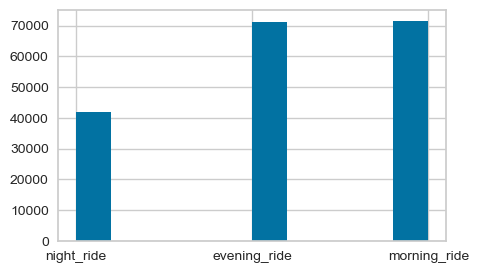

In [28]:
plt.figure(figsize=(5,3))
df_ride_data['ride_time'].hist()

<Axes: >

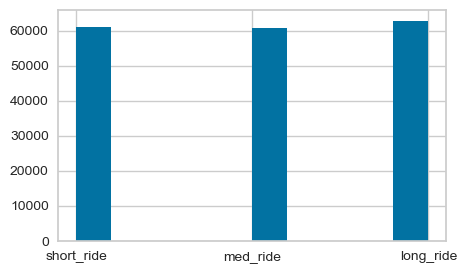

In [29]:
plt.figure(figsize=(5,3))
df_ride_data['ride_length'].hist()

#### Feature Engineering for Drivers

With all the rides data now available, we can complete the feature creation process, and convert these features from rides features to drivers features. So in this section, our goal is to reach data such as the driver and his features in the same row.

First, we calculate the number of rides taken by each driver on each day by creating a pivot table from a ride_data DataFrame. The pivot table has drivers' ids as row indices, ride dates as column indices, and the number of rides taken by each driver on each day as values. Any missing values in the pivot table are filled with zeros.

In [30]:
# calculate driver_perday_ridecount
driver_perday_ridecount = df_ride_data.pivot_table(index = 'driver_id', columns = 'ride_date', aggfunc='size')
driver_perday_ridecount.head(5)

ride_date                         2016-03-28  2016-03-29  2016-03-30  2016-03-31  2016-04-01  2016-04-02  2016-04-03  2016-04-04  2016-04-05  2016-04-06  2016-04-07  2016-04-08  2016-04-09  2016-04-10  2016-04-11  2016-04-12  2016-04-13  2016-04-14  2016-04-15  2016-04-16  2016-04-17  2016-04-18  2016-04-19  2016-04-20  2016-04-21  2016-04-22  2016-04-23  2016-04-24  2016-04-25  2016-04-26  2016-04-27  2016-04-28  2016-04-29  2016-04-30  2016-05-01  2016-05-02  2016-05-03  2016-05-04  2016-05-05  2016-05-06  2016-05-07  2016-05-08  2016-05-09  2016-05-10  2016-05-11  2016-05-12  2016-05-13  2016-05-14  2016-05-15  2016-05-16  2016-05-17  2016-05-18  2016-05-19  2016-05-20  2016-05-21  2016-05-22  2016-05-23  2016-05-24  2016-05-25  2016-05-26  2016-05-27  2016-05-28  2016-05-29  2016-05-30  2016-05-31  2016-06-01  2016-06-02  2016-06-03  2016-06-04  2016-06-05  2016-06-06  2016-06-07  2016-06-08  2016-06-09  2016-06-10  2016-06-11  2016-06-12  2016-06-13  2016-06-14  2016-06-15  \
driver_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
002be0ffdc997bd5c50703158b7c2491         NaN         6.0         NaN         8.0         7.0         5.0         NaN         NaN         7.0         NaN         2.0         NaN         1.0         1.0         2.0        11.0         7.0         3.0         5.0        11.0         4.0         NaN        10.0         7.0         4.0         1.0         6.0         1.0         NaN         2.0         1.0         NaN         NaN         NaN         NaN         NaN         NaN         NaN         7.0         3.0         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         3.0         NaN         7.0         2.0         7.0         6.0         3.0         1.0         NaN         NaN         5.0         NaN         5.0         2.0         2.0         NaN         NaN        13.0         NaN         8.0         4.0        10.0         7.0         9.0         5.0         8.0         6.0         4.0         2.0         3.0         4.0         NaN   
007f0389f9c7b03ef97098422f902e62         NaN         1.0         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         1.0         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         5.0         NaN         NaN         4.0         NaN         2.0         NaN         NaN         NaN         NaN         NaN         NaN         3.0         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         5.0         1.0         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         1.0         NaN         NaN         4.0         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         2.0         NaN   
011e5c5dfc5c2c92

Now we will create a new DataFrame called df_driver_info to store features about drivers. The following features are calculated and stored for each driver:

 - total_ride_count : Total number of rides for the driver.
 - total_distance : Total distance of rides for the driver.
 - total_duration : Total duration of rides for the driver.
 - lifetime_value : Total earnings (cost) of rides for the driver. This is the Driver's Lifetime Value referenced in the
 - first question of this assignment.
 - perday_ridecount_mean : Mean number of rides per day for the driver.
 - accept_response_time_mean : Mean accept response time for the driver.
 - arrival_time_mean : Mean arrival time for the driver.
 - wait_time_mean : Mean wait time for the driver.
 - short , medium , long : Total number of rides categorized by length.
 - day , evening , night : Total number of rides categorized by time.

The final DataFrame is filled with 0 for any missing values and we reset the index to start from 0.

In [31]:
df_driver_info = pd.DataFrame()
df_driver_info['total_ride_count'] = df_ride_data.pivot_table(index=['driver_id'], aggfunc='size')
df_driver_info['total_distance'] = df_ride_ids.groupby('driver_id')['ride_distance'].sum()
df_driver_info['total_duration'] = df_ride_ids.groupby('driver_id')['ride_duration'].sum()
df_driver_info['lifetime_value'] = df_ride_ids.groupby('driver_id')['total_ride_cost'].sum()
df_driver_info['perday_ridecount_mean'] = driver_perday_ridecount.mean(axis=1)
df_driver_info['accept_response_time_mean'] = (df_ride_data.groupby(df_ride_data['driver_id']).aggregate({'ride_accept_response_time': 'mean'})).iloc[:,0]
df_driver_info['arrival_time_mean'] = (df_ride_data.groupby(df_ride_data['driver_id']).aggregate({'ride_arrival_time': 'mean'})).iloc[:,0]
df_driver_info['wait_time_mean'] = (df_ride_data.groupby(df_ride_data['driver_id']).aggregate({'ride_wait_time': 'mean'})).iloc[:,0]
df_driver_info = pd.merge(df_driver_info, df_ride_data.pivot_table(index = 'driver_id', columns = 'ride_length', aggfunc='size') ,on='driver_id')
df_driver_info = pd.merge(df_driver_info, df_ride_data.pivot_table(index = 'driver_id', columns = 'ride_time', aggfunc='size') ,on='driver_id')

df_driver_info = df_driver_info.fillna(0).reset_index()
df_driver_info.head(5)

driver_id  total_ride_count  total_distance  total_duration  lifetime_value  perday_ridecount_mean  accept_response_time_mean  arrival_time_mean  wait_time_mean  long_ride  med_ride  short_ride  evening_ride  morning_ride  night_ride
0  002be0ffdc997bd5c50703158b7c2491               277         1740287          221238     3560.922486               4.946429                   0.140132           2.883153        0.087184         79       103          95         103.0          85.0        89.0
1  007f0389f9c7b03ef97098422f902e62                31          117531           20497      321.494700               2.583333                   0.197312           2.952688        0.081183          5        15          11          24.0           6.0         1.0
2  011e5c5dfc5c2c92501b8b24d47509bc                34          269653           29205      482.427858               2.833333                   0.121569           3.720588        0.068137         11        11          12          24.0           8.0         2.0
3  0152a2f305e71d26cc964f8d4411add9               191         1471239          174521     2610.868747               4.775000                   0.236649           3.908813        0.091885         99        51          41          17.0          67.0       107.0
4  01674381af7edd264113d4e6ed55ecda               375         3123644          357443     5381.091550               9.375000                   0.208800           3.608133        0.136800        157       111         107           0.0         350.0        25.0

Now, we can use the **df_driver_ids** DataFrame and calculate for how long do the drivers typically continue driving with 
Lyft. This is done by calculating the duration between their onboarding date and the date of their most recent rid, i 
days.

In [32]:
# Calc how long do the driver typically continue driving with Lyft
df_onboard_data = pd.merge(df_ride_data.groupby('driver_id').agg({'accepted_at': max}), df_driver_ids , on='driver_id')

# Calc. driver_duration the long of how driver continue driving with lyft par days
df_onboard_data['accepted_at'] = pd.to_datetime(df_onboard_data['accepted_at'])
df_onboard_data['driver_onboard_date'] = pd.to_datetime(df_onboard_data['driver_onboard_date'])
df_onboard_data['driver_duration'] = (df_onboard_data['accepted_at'] - df_onboard_data['driver_onboard_date']).dt.total_seconds()/(24*3600)
df_onboard_data = df_onboard_data[['driver_id', 'driver_duration']]
df_driver_info = pd.merge(df_driver_info, df_onboard_data, on= 'driver_id' , how='inner')
df_driver_info.head()


driver_id  total_ride_count  total_distance  total_duration  lifetime_value  perday_ridecount_mean  accept_response_time_mean  arrival_time_mean  wait_time_mean  long_ride  med_ride  short_ride  evening_ride  morning_ride  night_ride  driver_duration
0  002be0ffdc997bd5c50703158b7c2491               277         1740287          221238     3560.922486               4.946429                   0.140132           2.883153        0.087184         79       103          95         103.0          85.0        89.0        86.421181
1  007f0389f9c7b03ef97098422f902e62                31          117531           20497      321.494700               2.583333                   0.197312           2.952688        0.081183          5        15          11          24.0           6.0         1.0        85.553981
2  011e5c5dfc5c2c92501b8b24d47509bc                34          269653           29205      482.427858               2.833333                   0.121569           3.720588        0.068137         11        11          12          24.0           8.0         2.0        68.848924
3  0152a2f305e71d26cc964f8d4411add9               191         1471239          174521     2610.868747               4.775000                   0.236649           3.908813        0.091885         99        51          41          17.0          67.0       107.0        64.428229
4  01674381af7edd264113d4e6ed55ecda               375         3123644          357443     5381.091550               9.375000                   0.208800           3.608133        0.136800        157       111         107           0.0         350.0        25.0        56.544236

In [33]:
df_driver_info.describe()

total_ride_count  total_distance  total_duration  lifetime_value  perday_ridecount_mean  accept_response_time_mean  arrival_time_mean  wait_time_mean   long_ride    med_ride  short_ride  evening_ride  morning_ride  night_ride  driver_duration
count        837.000000    8.370000e+02      837.000000      837.000000             837.000000                 837.000000         837.000000      837.000000  837.000000  837.000000  837.000000    837.000000    837.000000  837.000000       837.000000
mean         220.082437    1.528516e+06   189242.789725     2979.856496               6.393533                   0.198516           4.417544        0.064720   74.874552   72.569892   72.637993     84.874552     85.178017   50.029869        55.719549
std          178.180347    1.259931e+06   154009.144305     2416.910596               2.790761                   0.069286           1.406403        0.127561   60.894880   60.813653   62.422290     81.688592     92.089711   64.935745        21.734015
min            3.000000    9.895000e+03     1712.000000       25.691307               1.000000                   0.084074           1.668056       -1.387415    1.000000    1.000000    1.000000      0.000000      0.000000    0.000000         1.733611
25%           44.000000    3.390140e+05    38363.000000      618.243082               4.300000                   0.158730           3.458333        0.034524   18.000000   14.000000   14.000000     17.000000     15.000000    5.000000        42.810752
50%          224.000000    1.451389e+06   189906.000000     2959.138312               6.200000                   0.184409           4.104848        0.059024   71.000000   72.000000   72.000000     60.000000     44.000000   22.000000        57.919340
75%          330.000000    2.311846e+06   288097.000000     4476.530019               8.151515                   0.221540           5.042160        0.115833  114.000000  111.000000  112.000000    140.000000    139.000000   74.000000        73.090023
max          919.000000    6.628201e+06   779797.000000    12350.274946              17.500000                   0.687500          12.045238        0.491954  335.000000  294.000000  313.000000    404.000000    515.000000  470.000000        90.771134

Here we are plotting histograms to visualize the distribution of the data in each column and identify any potential outliers or skewness in the data. This can help to better understand the data and identify any potential issues that may need to be addressed before modeling and analysis.

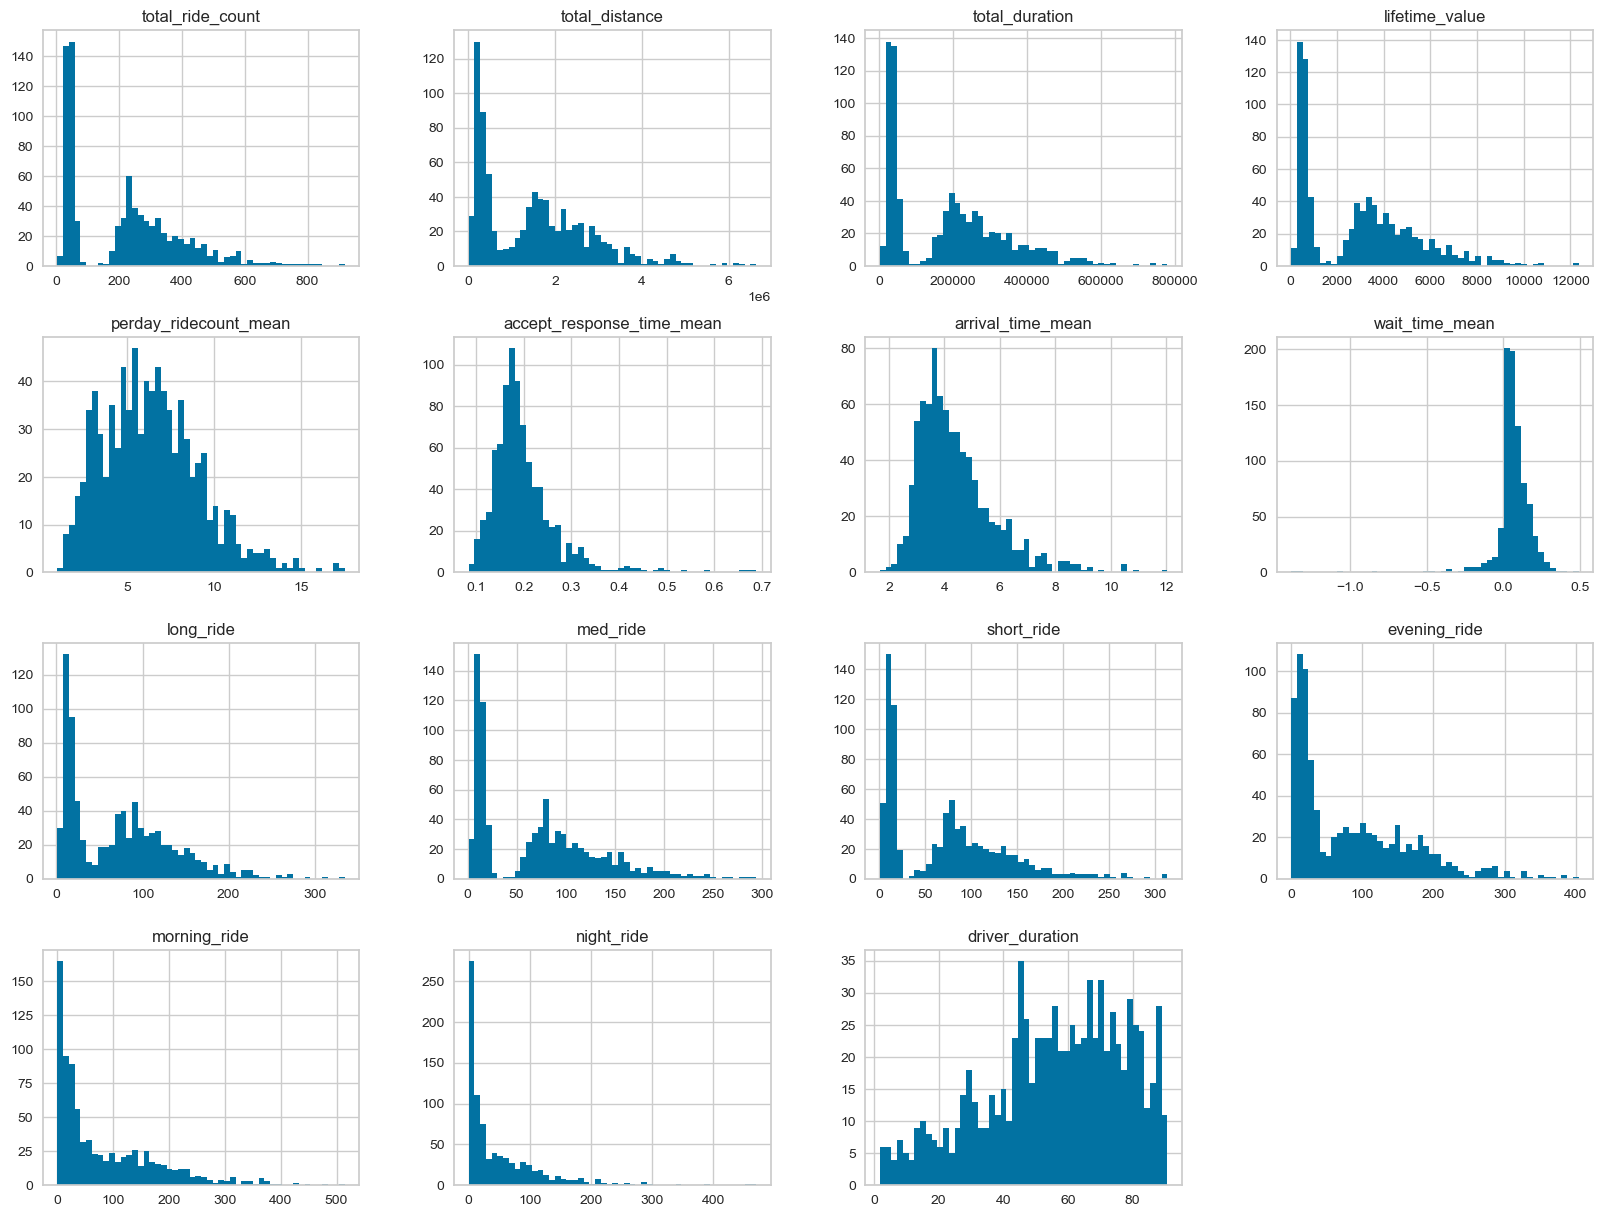

In [34]:
df_driver_info.hist(bins=50, figsize=(20, 15))
plt.show()

Next, we use the ***pairplot()*** function from the seaborn library to generate scatter plots for each combination of variables in the ***df_driver_info*** DataFrame. The function creates a matrix of plots, where each plot represents the relationship between two variables. This can help to visually identify any correlations or patterns in the data, and we can see the relationship between the total lifetime value and all variables, the relationship between all variables, and the driver duration with Lyft.

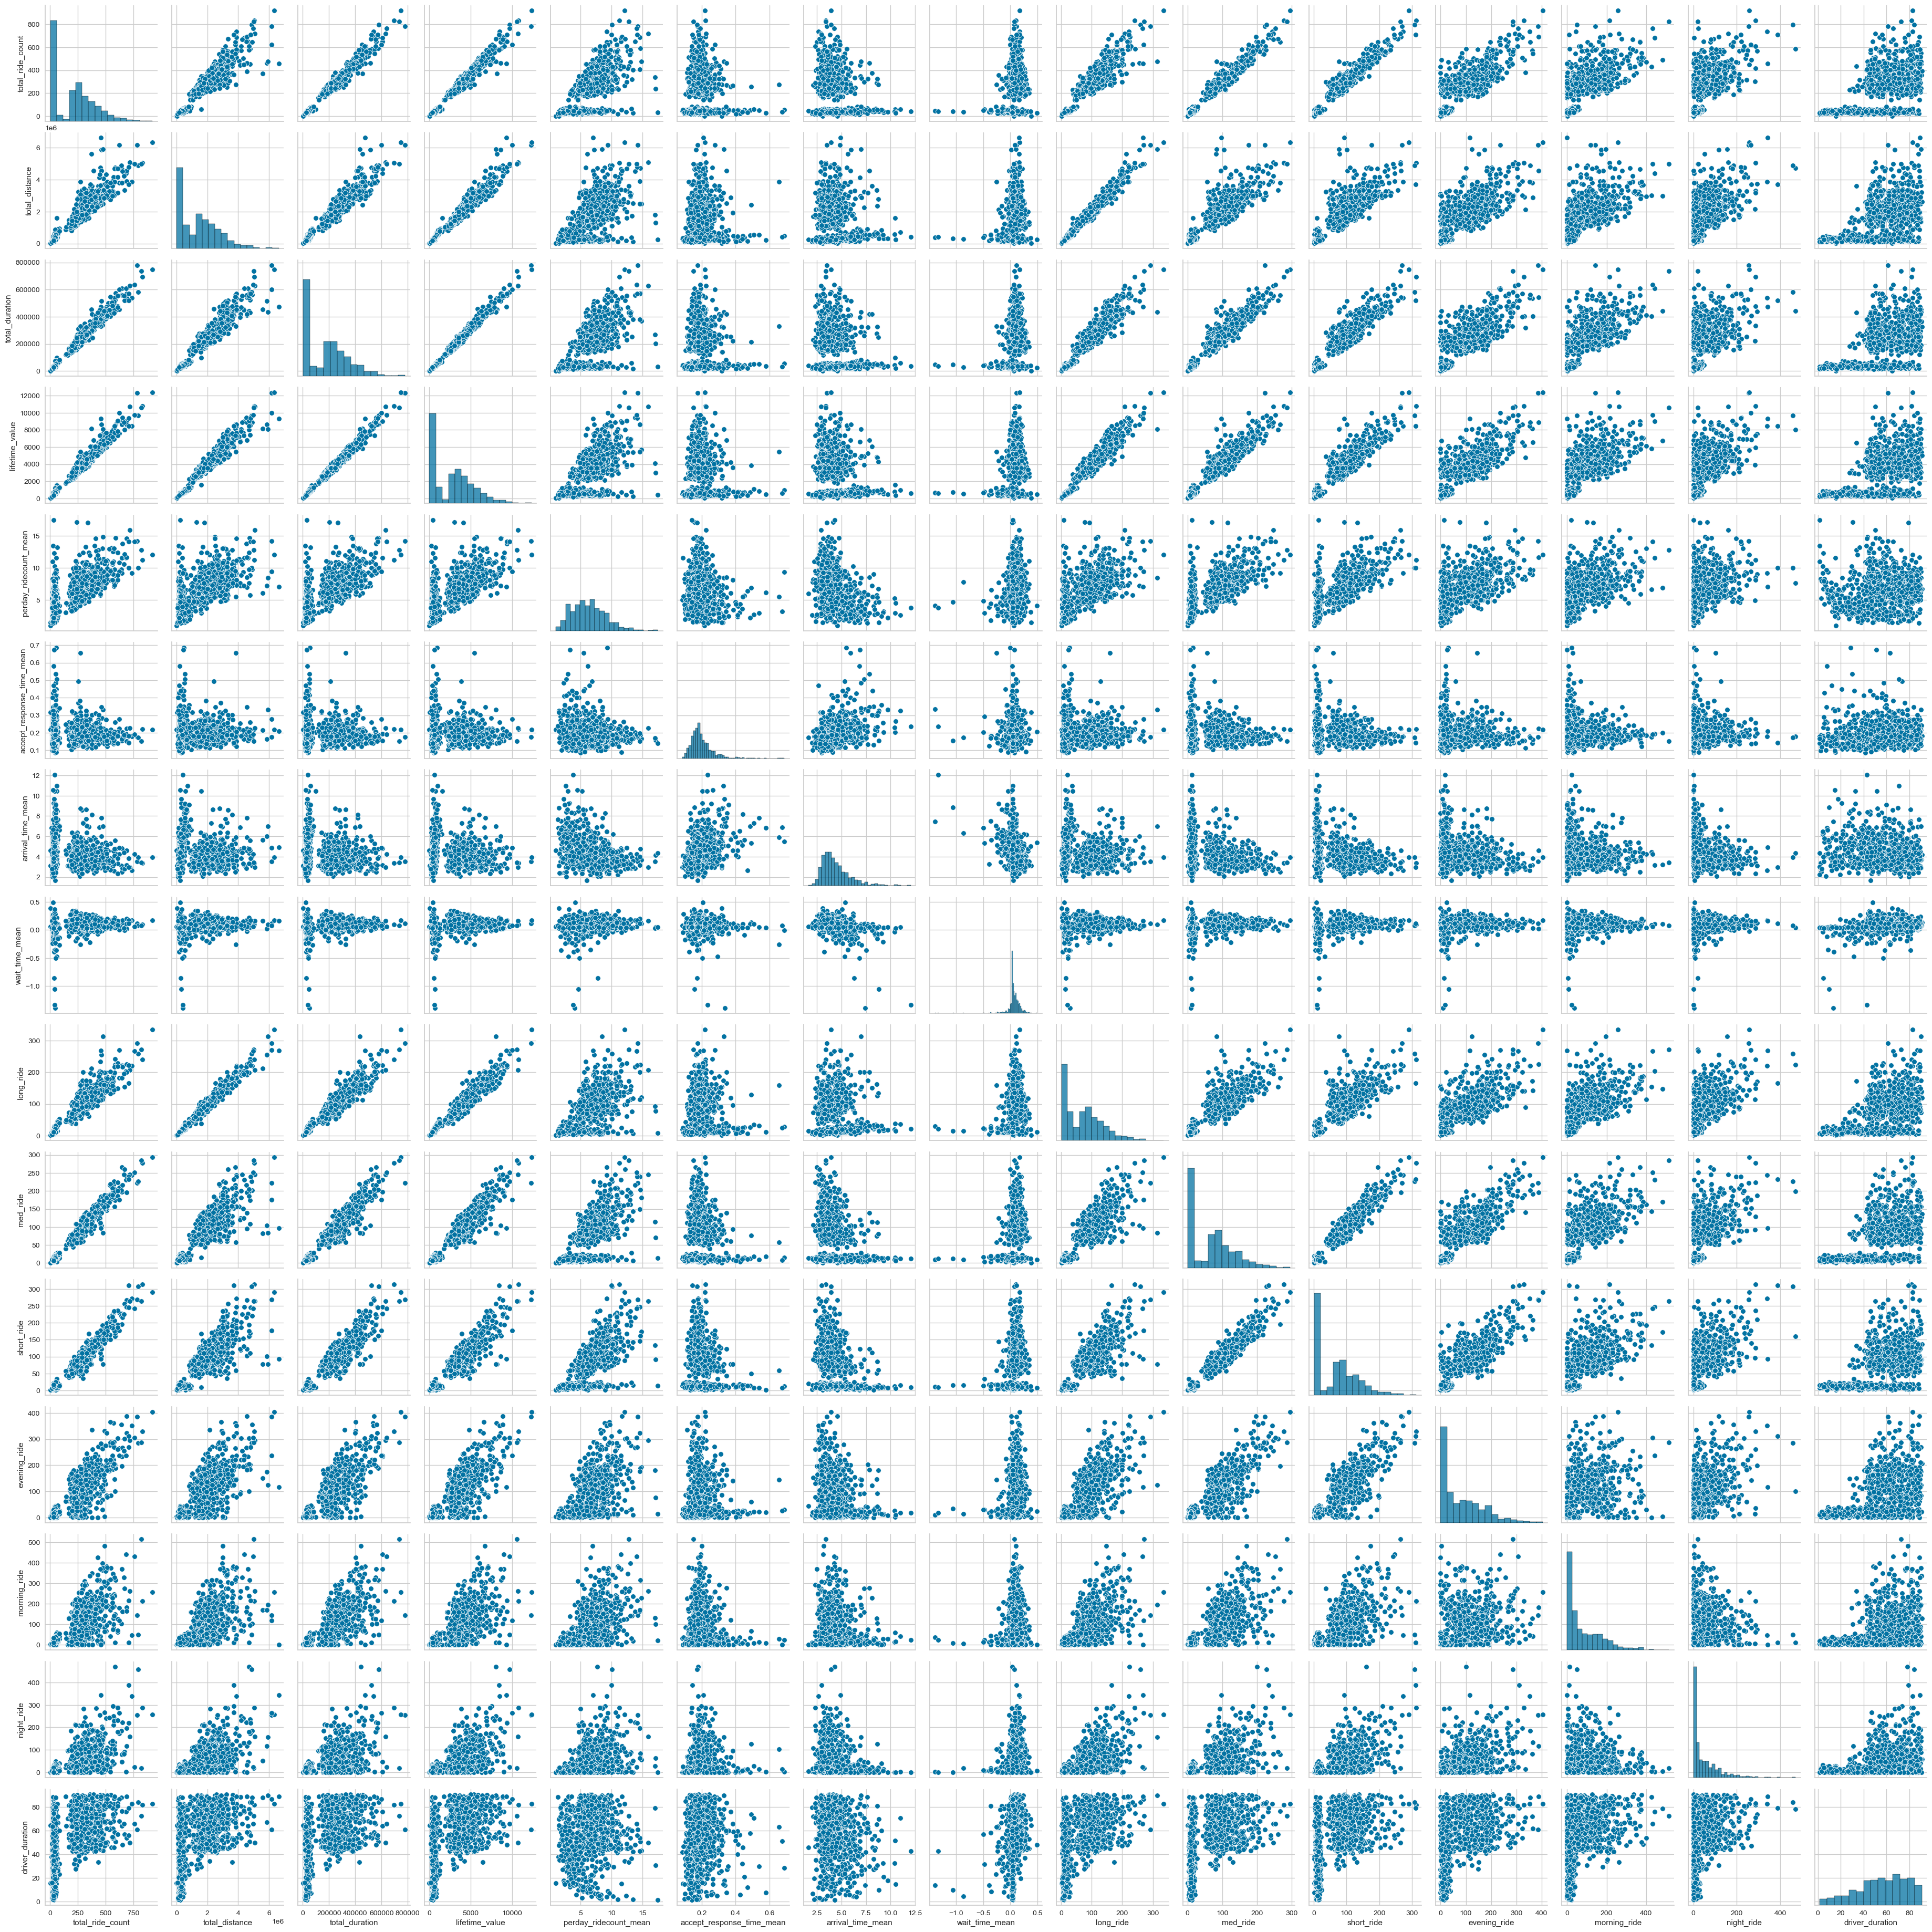

In [35]:
# scatter plots of data
sns.pairplot(df_driver_info)

#### Main Factors Affecting a Driver's Lifetime Value

To answer the second question of this assignment, we can use a correlation matrix.

First, we use the heatmap() function from the seaborn library to generate a heatmap of the correlations between the variables in the driver_info DataFrame. A heatmap is a graphical representation of data where individual values are represented as colors.

<Axes: >

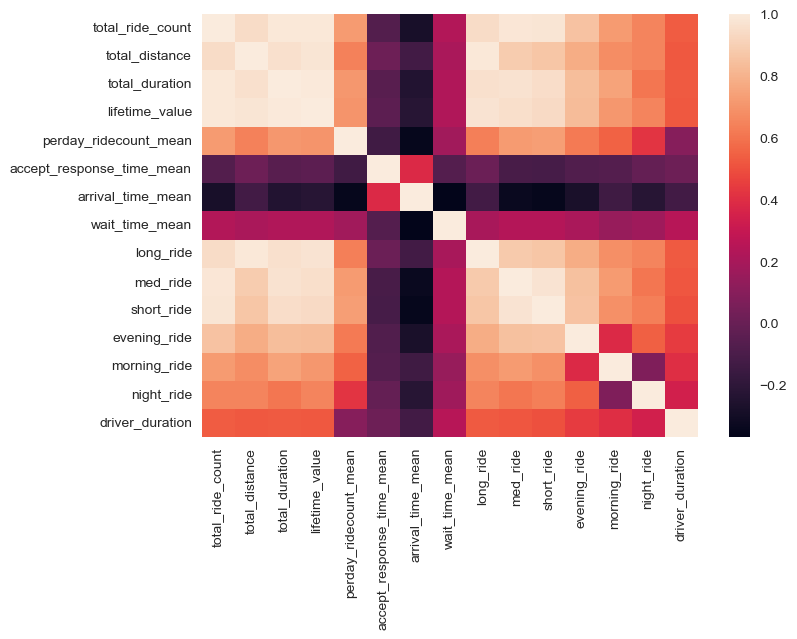

In [36]:
# Heatmap for correlations betweem features
df = df_driver_info[[
    'total_ride_count', 'total_distance', 'total_duration', 'lifetime_value', 'perday_ridecount_mean', 'accept_response_time_mean', 
    'arrival_time_mean', 'wait_time_mean', 'long_ride', 'med_ride', 'short_ride', 'evening_ride', 'morning_ride', 'night_ride', 
    'driver_duration'
]]

sns.heatmap(df.corr())

In the code below, we calculate the correlation coefficient between each feature in the driver_info DataFrame and the target variable **lifetime_value**.

Then, we sort the correlation coefficients in descending order, to provide information on which features are most strongly correlated with the target variable.

In [37]:
# get a correlation with lifetime_value as a DataFrame sorted in descending order
pd.DataFrame(df.corr()['lifetime_value']).sort_values(by= 'lifetime_value' , ascending=False).iloc[1:]

lifetime_value
total_duration                   0.994191
total_ride_count                 0.987063
total_distance                   0.978461
long_ride                        0.971446
med_ride                         0.954131
short_ride                       0.940289
evening_ride                     0.833408
morning_ride                     0.710680
perday_ridecount_mean            0.697549
night_ride                       0.652169
driver_duration                  0.523931
wait_time_mean                   0.226384
accept_response_time_mean       -0.040446
arrival_time_mean               -0.228536

#### Average Projected Lifetime of a Driver

This code is creating a graph that shows how long Lyft drivers have been working for the company. The graph is a histogram, which shows how many drivers have worked for different lengths of time. The code sets the labels for the xaxis (which shows the length of time) and the y-axis (which shows the number of drivers) and then displays the graph.

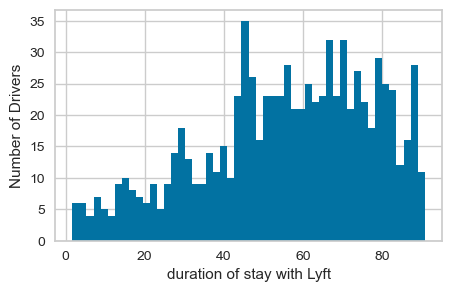

In [38]:
plt.figure(figsize=(5,3))
df_driver_info['driver_duration'].plot.hist(bins=50)
plt.xlabel('duration of stay with Lyft')
plt.ylabel('Number of Drivers')
plt.show()

In [39]:
df_driver_info['driver_duration'].describe()

count    837.000000
mean      55.719549
std       21.734015
min        1.733611
25%       42.810752
50%       57.919340
75%       73.090023
max       90.771134
Name: driver_duration, dtype: float64

We can see from the above table and from the histogram that the average lifetime of a driver is about 55 days.

#### Do All Drivers Act Alike? - Clustering Exercise

To answer this question we will do a segmentation model using K-Means Clustering, to help us to know if all drivers act alike or not, and of there specific segments of drivers that generate more value for Lyft than the average driver or not. 

We use ***KElbowVisualizer*** to determine the optimal number of clusters for a K-Means Clustering model. The visualization helps to select the number of clusters by finding the "elbow" point in the plot of the explained variance as a function of the number of clusters. The "elbow" point represents the trade-off between simplicity and the explained variance; the optimal number of clusters is typically chosen at the elbow point, which is the point of diminishing returns.

The ***KElbowVisualizer*** fits the KMeans model on the input data (driver_info after dropping the driver_id column) and plots the explained variance for different values of k (number of clusters), ranging from 2 to 12.

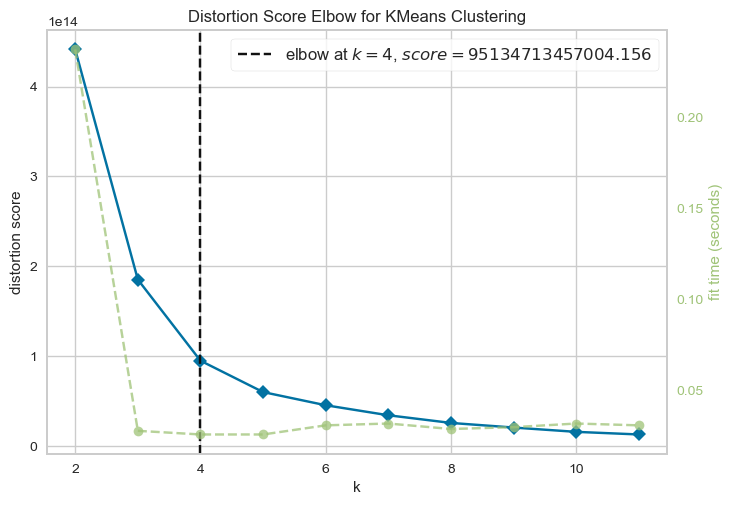

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [40]:
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2,12))
visualizer.fit(df_driver_info.drop(['driver_id'], axis=1))
visualizer.show()

**Our best k is 4, so we will use it to segment the data.**

In the cell below, the K-Means Clustering algorithm is used to group similar drivers based on the features in the ***df_driver_info*** DataFrame. The number of clusters is set to 4, which is determined using the KElbowVisualizer. The KMeans model is then fit on the data by dropping the driver_id column. The result of the fit will be cluster labels for each driver.

In [41]:
# Fit a K-Means model with the optimal number of clusters
kmeans = KMeans(n_clusters=visualizer.elbow_value_, random_state=42)
kmeans.fit(df_driver_info.drop(['driver_id'], axis=1))

KMeans(n_clusters=4, random_state=42)

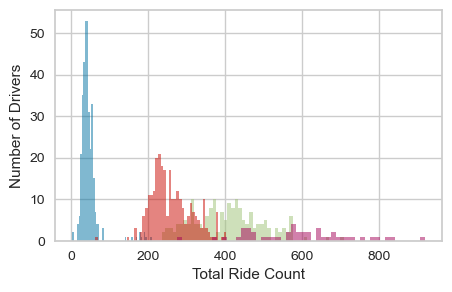

In [42]:
# Add the cluster labels to the dataframe
df_driver_info['cluster'] = kmeans.labels_

# Plot the distribution of total ride count by cluster
plt.figure(figsize=(5,3))
df_driver_info.groupby('cluster')['total_ride_count'].plot.hist(bins=50, alpha=0.5)
plt.xlabel('Total Ride Count')
plt.ylabel('Number of Drivers')
plt.show()

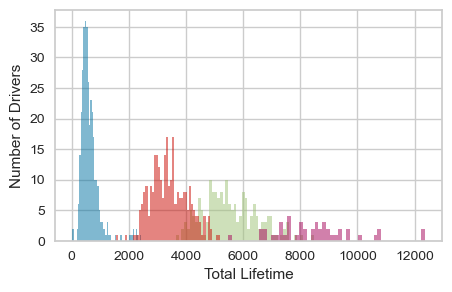

In [43]:
# Plot the distribution of total earnings by cluster
plt.figure(figsize=(5,3))
df_driver_info.groupby('cluster')['lifetime_value'].plot.hist(bins=50, alpha=0.5)
plt.xlabel('Total Lifetime')
plt.ylabel('Number of Drivers')
plt.show()

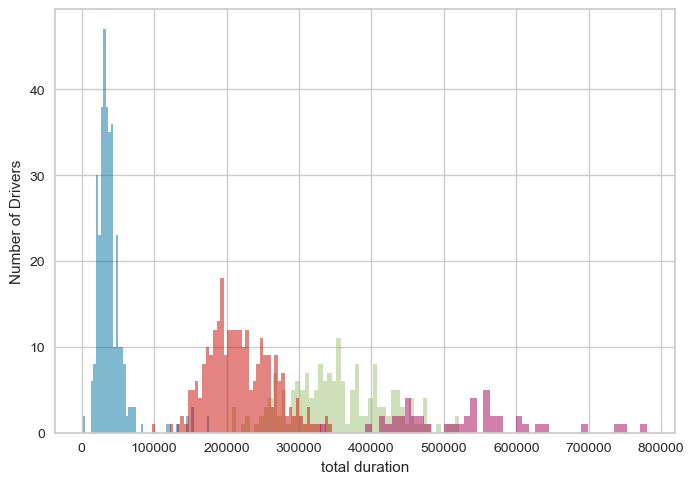

In [44]:
# Plot the distribution of total duration by cluster
# plt.figure(figsize=(5,3))
df_driver_info.groupby('cluster')['total_duration'].plot.hist(bins=50, alpha=0.5)
plt.xlabel('total duration')
plt.ylabel('Number of Drivers')
plt.show()

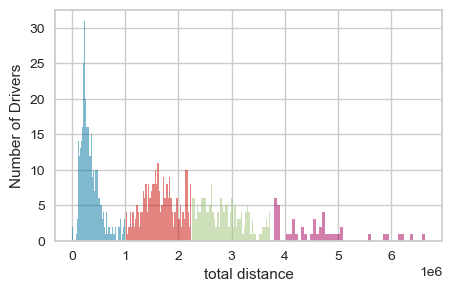

In [45]:
# Plot the distribution of total distance by cluster
plt.figure(figsize=(5,3))
df_driver_info.groupby('cluster')['total_distance'].plot.hist(bins=50, alpha=0.5)
plt.xlabel('total distance')
plt.ylabel('Number of Drivers')
plt.show()

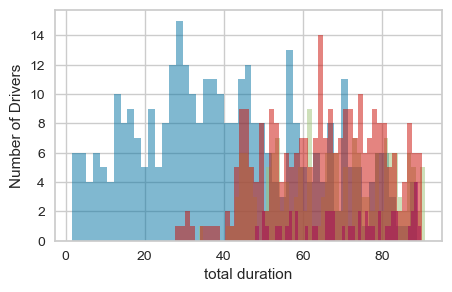

In [46]:
# Plot the distribution of driver's lifetime by cluster
plt.figure(figsize=(5,3))
df_driver_info.groupby('cluster')['driver_duration'].plot.hist(bins=50, alpha=0.5)
plt.xlabel('total duration')
plt.ylabel('Number of Drivers')
plt.show()

In [47]:
grouped_df = df_driver_info.groupby('cluster')[['lifetime_value','med_ride', 'perday_ridecount_mean', 'total_ride_count', 'short_ride',
'total_duration', 'total_distance', 'long_ride', 'evening_ride', 'night_ride', 'morning_ride', 'driver_duration', 'wait_time_mean']].agg('mean')

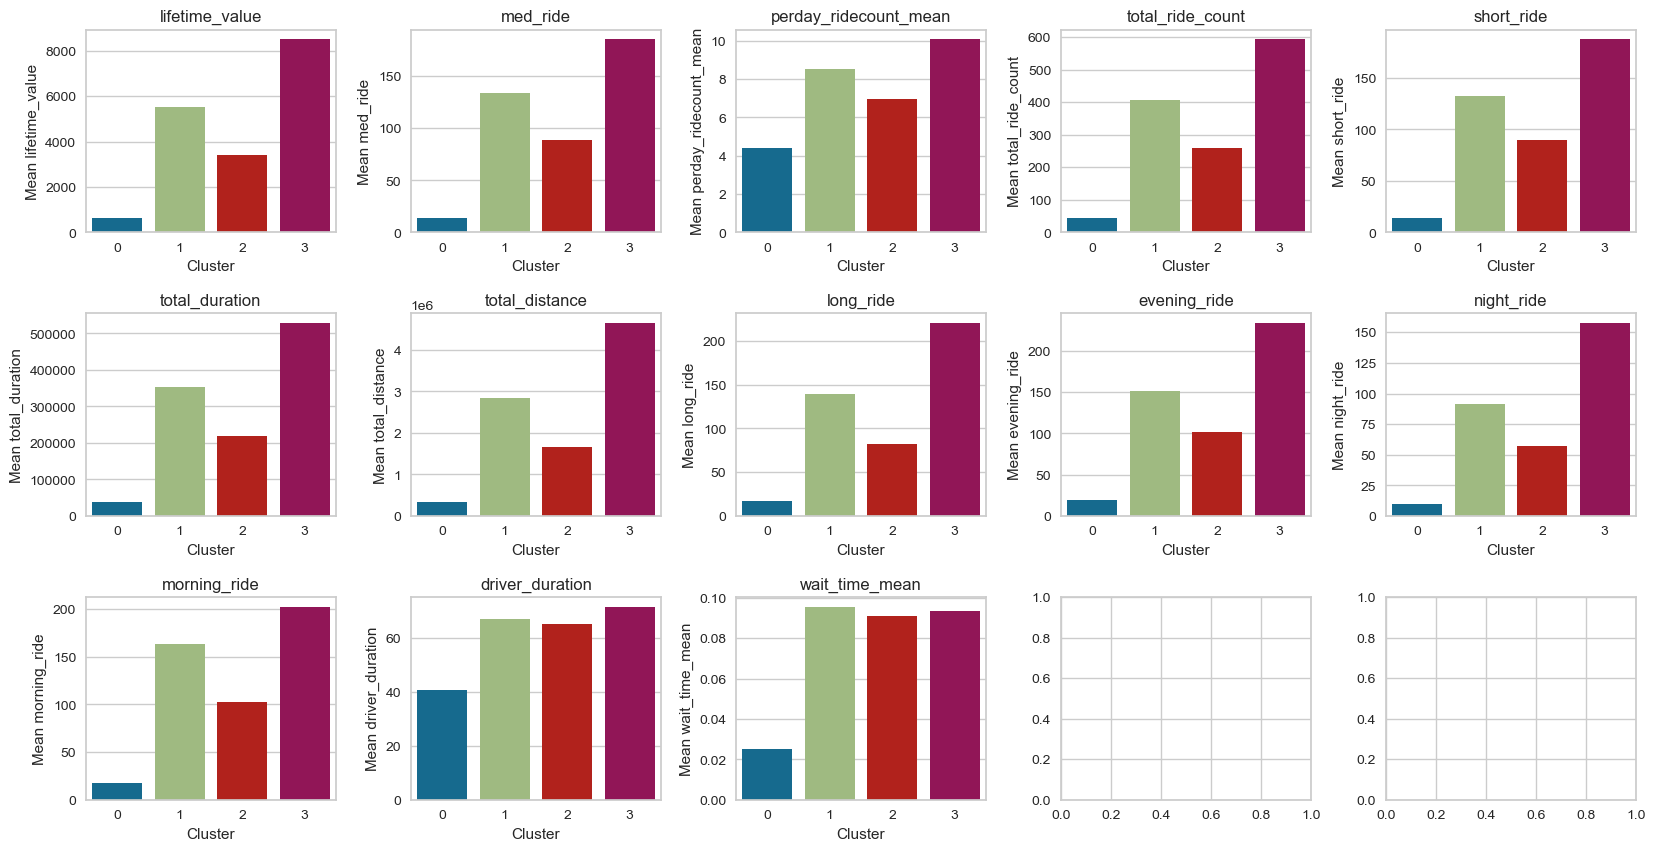

In [48]:
# create subplots for each column in the grouped dataframe
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20,10))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

for i, column in enumerate(grouped_df.columns):
    sns.barplot(x=grouped_df.index, y=grouped_df[column], ax=axes[i//5, i%5])
    axes[i//5, i%5].set_title(column)
    axes[i//5, i%5].set_xlabel('Cluster')
    axes[i//5, i%5].set_ylabel('Mean ' + column)

plt.show()


After seeing these plots we can define clusters as bad drivers, fair drivers, good drivers, and excellent drivers:

 - **Cluster 0 is Bad drivers**: This cluster has drivers with relatively low total lifetime value, low total ride count, and low total duration and distance. They may have issues with customer service, low demand for their services, or low fares.
 - **Cluster 1 is Good drivers**: This cluster has drivers with higher total lifetime value, higher ride count, and higher total duration and distance than the first two clusters. They may have a consistent demand for their services and a good reputation, leading to higher earnings.
 - **Cluster 2 is Fair drivers**: This cluster has drivers with moderate total lifetime value, ride count, duration, and distance. They may not have a high demand for their services, but they also do not have any major issues that impact their earnings.
 - **Cluster 3 is Excellent drivers**: This cluster has drivers with the highest total lifetime value, ride count, and total duration and distance. These drivers are likely the most in demand and have a good reputation for providing excellent service to their customers, leading to high earnings.


### Actionable Recommendations

 - Focus on retaining good and excellent drivers: The business should focus on retaining the drivers who belong to the good and excellent clusters as they bring in more revenue and have more frequent rides compared to other drivers.
 - Target improvement of fair drivers: The business should target to improve the performance of fair drivers, to convert them into good or excellent drivers.
 - Identify and address issues faced by bad drivers: The business should identify and address the issues faced by the bad drivers, such as low earnings, low ride frequency, and low ride duration, to improve their performance.
 - Personalized incentives and training: The business can offer personalized incentives and training to drivers based on their performance clusters to further improve their performance.
 - Use clustering results for dynamic pricing: The clustering results can be used for dynamic pricing, where prices can be adjusted based on the supply and demand of drivers in a particular area.
 - Monitor performance regularly: The business should regularly monitor the performance of drivers and reassess them based on the clustering results to ensure that they are being properly targeted with the appropriate incentives and support.
